In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
import metpy.calc as mpcalc
from metpy.units import units
from numpy import *
import xarray as xr
from netCDF4 import Dataset, num2date
import math
import sys
from datetime import datetime, timedelta

import cdsapi
import os

In [2]:
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None, ax=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color
    lon = plotting longitude values (2D)
    lat = plotting latitude values (2D)
    data = 2D data that you wish to plot the max/min symbol placement
    extrema = Either a value of max for Maximum Values or min for Minimum Values
    nsize = Size of the grid box to filter the max and min values to plot a reasonable number
    symbol = String to be placed at location of max/min value
    color = String matplotlib colorname to plot the symbol (and numerica value, if plotted)
    plot_value = Boolean (True/False) of whether to plot the numeric value of max/min point
    ax = axes object to plot onto, defaults to current axes
    The max/min symbol will be plotted only within the bounding frame
    (i.e., clip_on=True, clip_box=ax.bbox)
    """
    import matplotlib.pyplot as plt
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if ax is None:
        ax = plt.gca()
    
    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')
        
    mxy, mxx = where(data_ext == data)
    
    for i in range(len(mxy)):
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=36,
                     clip_on=True, clip_box=ax.bbox, horizontalalignment='center', verticalalignment='center',
                     transform=transform)
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
                     '\n' + str(int(data[mxy[i], mxx[i]])),
                     color=color, size=12, clip_on=True, clip_box=ax.bbox, fontweight='bold',
                     horizontalalignment='center', verticalalignment='top', transform=transform)

In [3]:
############# Declare time, level, and lat/lon boundaries here ##########
startdate = '09/28/21 12:00' ## must be in this format 'MM/DD/YY HH:MM'
latN = 90
latS = 0
lonW = 250    # must be in degrees E (The western hemisphere is captured between 180 and 360 degrees east)
lonE = 360
date = datetime.strptime(startdate,'%m/%d/%y %H:%M')
level1 = 250
level2 = 850

# new stuff
bounds = [-90, -20, 10, 60]

In [4]:
######### Download ERA5 data using CDS-API ##########
os.chdir("/Users/etmu9498/research/data/era5/")
filestr = 'upper_'+date.strftime('%Y')+date.strftime('%m')+date.strftime('%d')+'_'+date.strftime('%H')+'00.nc'     # you can change these filenames as you see fit
filestr2 = 'surface_'+date.strftime('%Y')+date.strftime('%m')+date.strftime('%d')+'_'+date.strftime('%H')+'00.nc'


In [10]:
c = cdsapi.Client()
c.retrieve('reanalysis-era5-pressure-levels', {
    'product_type': 'reanalysis',
    'variable': ['u_component_of_wind', 'v_component_of_wind'],
    'pressure_level': ['250', '850'],
    'year': date.strftime('%Y'),         # substitutes the year based off the startdate in the above cell
    'month': date.strftime('%m'),        # substitutes the month based off the startdate in the above cell
    'day': date.strftime('%d'),          # substitutes the year based off the startdate in the above cell
    'time': date.strftime('%H:%M'),      # substitutes the time based off the startdate in the above above
    'format': 'netcdf',
    }, filestr)

'''
c.retrieve(
    'reanalysis-era5-single-levels', {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': 'mean_sea_level_pressure',
        'year': date.strftime('%Y'),         # substitutes the year based off the startdate in the above cell
        'month': date.strftime('%m'),        # substitutes the month based off the startdate in the above cell
        'day': date.strftime('%d'),          # substitutes the year based off the startdate in the above cell
        'time': date.strftime('%H:%M'),      # substitutes the time based off the startdate in the above above
    }, filestr2)
'''

2023-05-15 14:26:11,236 INFO Welcome to the CDS
2023-05-15 14:26:11,236 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2023-05-15 14:26:11,430 INFO Request is completed
2023-05-15 14:26:11,430 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data0/adaptor.mars.internal-1684181779.4880242-25617-9-b573fdc8-7eb3-4530-aa4c-2ed2052a9005.nc to upper_20210928_1200.nc (7.9M)
2023-05-15 14:26:15,116 INFO Download rate 2.2M/s                                                                      


"\nc.retrieve(\n    'reanalysis-era5-single-levels', {\n        'product_type': 'reanalysis',\n        'format': 'netcdf',\n        'variable': 'mean_sea_level_pressure',\n        'year': date.strftime('%Y'),         # substitutes the year based off the startdate in the above cell\n        'month': date.strftime('%m'),        # substitutes the month based off the startdate in the above cell\n        'day': date.strftime('%d'),          # substitutes the year based off the startdate in the above cell\n        'time': date.strftime('%H:%M'),      # substitutes the time based off the startdate in the above above\n    }, filestr2)\n"

In [5]:
######## Enter in the datasets #########
print(filestr)

sys.path.append("/Users/etmu9498/research/data/era5")
# os.chdir("/Users/etmu9498/research/data/era5/")
ds = xr.open_dataset(filestr).metpy.parse_cf()

# ds2 = xr.open_dataset(filestr2).metpy.parse_cf()

ds

upper_20210928_1200.nc


<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, level: 2, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 250 850
  * time       (time) datetime64[ns] 2021-09-28T12:00:00
    metpy_crs  object Projection: latitude_longitude
Data variables:
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-15 20:16:19 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [66]:
######## Read in the variables ##########
'''
pmsl = ds2.msl.metpy.sel(time=date,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
pmsl_hilo = ds2.msl.metpy.sel(time=date,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
lats = ds2.latitude.metpy.sel(latitude=slice(latN,latS))
lons = ds2.longitude.metpy.sel(longitude=slice(lonW,lonE))
lons_2D, lats_2D = meshgrid(lons,lats)
geop1 = ds.z.metpy.sel(time=date,level = level1,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
geop2 = ds.z.metpy.sel(time=date,level = level2,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
'''

# upper wind
uwnd1 = ds.u.metpy.sel(time=date,level = level1,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
vwnd1 = ds.v.metpy.sel(time=date,level = level1,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
# lower wind
uwnd2 = ds.u.metpy.sel(time=date,level = level2,latitude=slice(latN,latS),longitude=slice(lonW,lonE))
vwnd2 = ds.v.metpy.sel(time=date,level = level2,latitude=slice(latN,latS),longitude=slice(lonW,lonE))

dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# hght1 = geop1/9.81    # need to divide the geopotential by gravity to get the geopotential height
# hght2 = geop2/9.81
corl = 2.0*7.292e-5*sin(lats*(pi/180.)) / units.second     # Coriolis Parameter

######### Smooth the variables ##########
# hght1 = mpcalc.smooth_gaussian(hght1,25)
# hght2 = mpcalc.smooth_gaussian(hght2,25)
# pmsl = mpcalc.smooth_gaussian(pmsl,25)
uwnd1 = mpcalc.smooth_gaussian(uwnd1,5)
vwnd1 = mpcalc.smooth_gaussian(vwnd1,5)

########### Calculate additional variables to plot #########
coriolis = mpcalc.coriolis_parameter(lats_2D*units.degrees)

'''
geo = mpcalc.geostrophic_wind( hght1,dx=dx,dy=dy,latitude=lats_2D*units.degrees)   # Geostrophic wind
age = mpcalc.ageostrophic_wind( hght1,uwnd,vwnd,dx=dx,dy=dy,latitude=lats)    # Ageostrophic wind
ug = geo[0]
vg = geo[1]
ua = age[0]
va = age[1]
'''

########### Calculate additional variables to plot #########
# thck = hght2 - hght1     # thickness

wspd1 = mpcalc.wind_speed(uwnd1,vwnd1)   # wind speed
wspd2 = mpcalc.wind_speed(uwnd2,vwnd2)   # wind speed

########## Scale the pressure so it plots correctly #########
scale = -2     # units of pmsl are Pa , this turns it to hPa

2021-09-28 12:00:00


C:\Users\etmu9498\AppData\Local\Temp\ipykernel_35636\2894505723.py:22: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter, minimum_filter
C:\Users\etmu9498\AppData\Local\Temp\ipykernel_35636\2894505723.py:22: DeprecationWarning: Please use `minimum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter, minimum_filter


plot 0 created


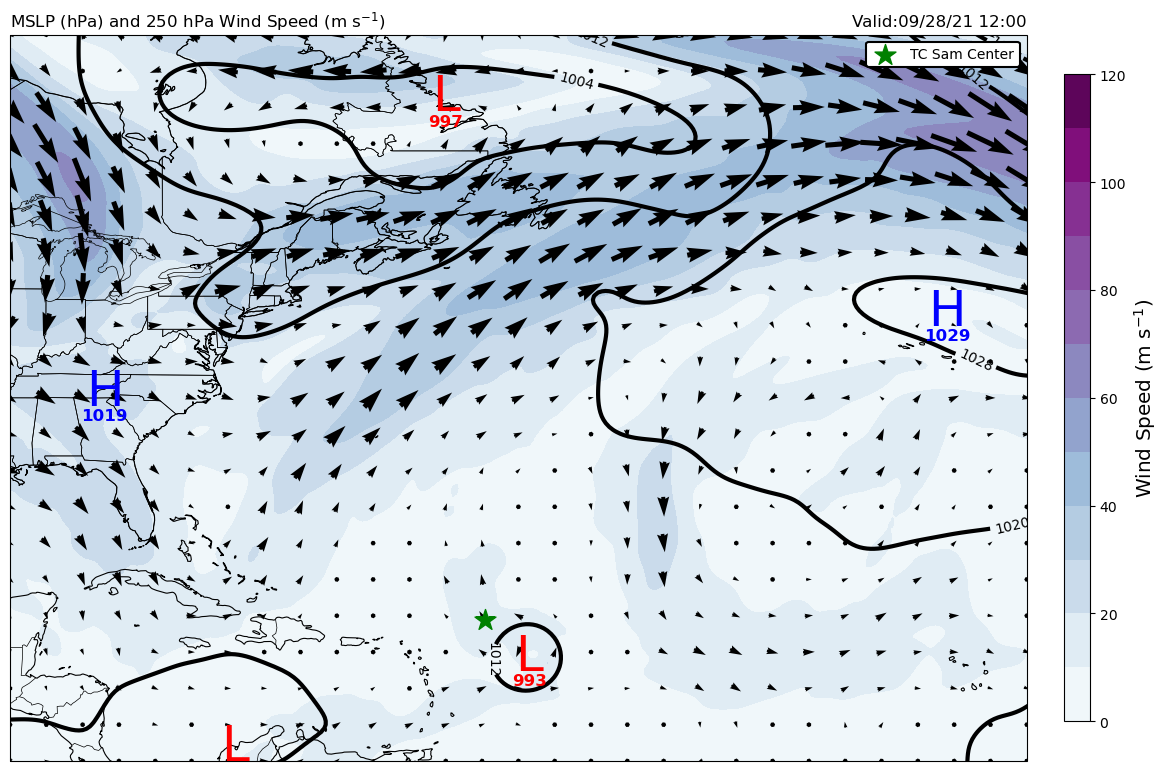

plot 1 created


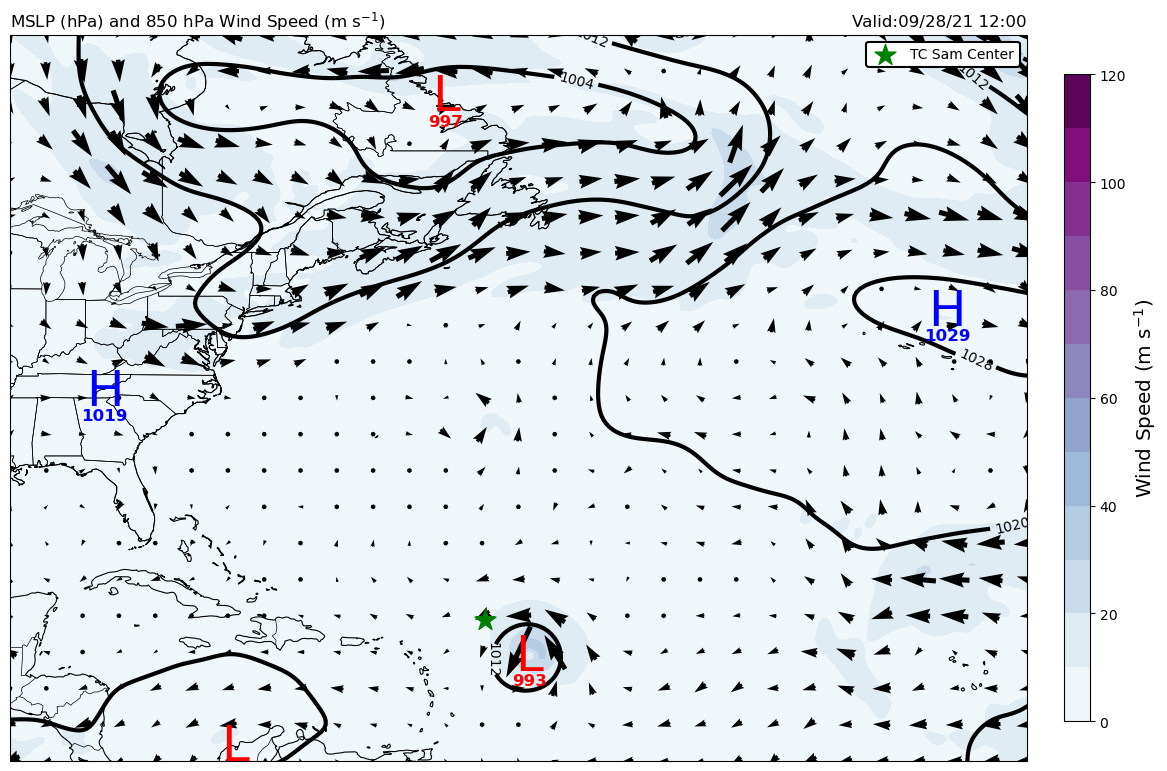

In [71]:
######## Create the plot #######

us = [uwnd1, uwnd2]
vs = [vwnd1, vwnd2]
spds = [wspd1, wspd2]
levels = [level1, level2]

for i in range(2):
    #Set up the projection that will be used
    mapcrs = ccrs.LambertConformal(central_longitude=-55, central_latitude=45, standard_parallels=(33, 45)) 
    mapcrs = ccrs.PlateCarree()

    #Set up the projection of the data; if lat/lon then PlateCarree is what you want
    datacrs = ccrs.PlateCarree()

    #Start the figure and create plot axes with proper projection
    fig = plt.figure(1, figsize= (16, 14))
    ax = plt.subplot(111, projection=mapcrs) 

    ax.set_extent( bounds, ccrs.PlateCarree()) ## Can change the lat/lon bounds

    #Add geopolitical boundaries for map reference
    ax.add_feature(cfeature.LAND, facecolor="#bdbdbd") 
    countries = NaturalEarthFeature(category="cultural", scale="110m", facecolor="none", name="admin_0_boundary_lines_land") 
    ax.add_feature(countries, linewidth=0.5, edgecolor="black") 
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5) 
    ax.coastlines('50m', linewidth=0.8)

    #Set up contour and fill intervals
    pmsl_levels = arange(940,1080,8) 
    wspd_levels = arange(0,130,10)

    #Plot the variables
    wspd_fcontours = plt.contourf(lons, lats, spds[i], levels=wspd_levels, cmap=get_cmap('BuPu'), alpha=1, transform=ccrs.PlateCarree())
    pmsl_contours = plt.contour(lons, lats, pmsl*10**scale, levels=pmsl_levels, colors="black", linewidths=3.0, transform=ccrs.PlateCarree())
    plot_maxmin_points(lons_2D, lats_2D, pmsl_hilo*10**scale, 'max', 100, symbol='H', color='b', transform=datacrs) 
    plot_maxmin_points(lons_2D, lats_2D, pmsl_hilo*10**scale, 'min', 100, symbol='L', color='r', transform=datacrs)

    # Plot total wind barbs
    udivbrb = us[i] 
    vdivbrb = vs[i]

    wind_slice = (slice(None, None, 10), slice(None, None, 10))
    ax.quiver(lons[wind_slice[0]], lats[wind_slice[1]],
              udivbrb[wind_slice], # .m
              vdivbrb[wind_slice], # .m
              pivot='mid', color='black',
              #scale=0.5e-6, scale_units='inches',
              width=0.005,
              transform=datacrs)


    #Colorbar and contour labels
    cb = fig.colorbar(wspd_fcontours, orientation='vertical', pad=0.03, extendrect=True, aspect=25, shrink=0.6)
    cb.set_label('Wind Speed (m s$^{-1}$)', size='x-large') 
    # plt.clabel(thck1_contours, fmt='%d') 
    # plt.clabel(thck2_contours, fmt='%d') 
    plt.clabel(pmsl_contours, fmt='%d')

    plt.grid('on')

    plt.scatter( [-57.3], [19.7], c='g', s=250, marker='*', label='TC Sam Center', zorder=5)
    leg = plt.legend(loc='upper right', framealpha=1.0, fontsize=10)
    leg.get_frame().set_linewidth( 1.5) 
    leg.get_frame().set_edgecolor('k')


    #Plot two titles, one on right and left side
    plt.title('MSLP (hPa) and ' + str( levels[i]) + ' hPa Wind Speed (m s$^{-1}$)', loc='left') 
    plt.title('Valid:'+startdate, loc='right')
    
    print( 'plot ' + str(i) + " created")
    
    plt.show()